## Undistort Camera Image and Lane finding

### Import Python Modules

In [1]:
def modules():
    global pickle, cv2, np, plt, mping, numpy, matplotlib, pyplot, matplotlib, image
    import pickle
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg

    print('Importing modules completed')

### Import Pickle files

Import the object and image points generated in camera calibration code to remove distortion.

In [2]:
def load_pickle():
    # Read in the saved objpoints and imgpoints
    pickle_in = open("objpoints_udacity.pickle", "rb")
    objpoints = pickle.load(pickle_in)

    pickle_in1 = open("imgpoints_udacity.pickle", "rb")
    imgpoints = pickle.load(pickle_in1)

    print('objpoints and imgpoints imported')
    return objpoints, imgpoints

### Camera Calibration Function

In [3]:
def cal_undistort(img, objpoints, imgpoints):
    img = img

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)

    return dst

### RGB color channels

In [4]:
def RGB(undistorted):
    R = undistorted[:, :, 0]
    G = undistorted[:, :, 1]
    B = undistorted[:, :, 2]
    return R, G, B

### Convert it to binary image

In [5]:
def RGB_binary(gray, R, G, B):
    thresh = (150, 255)

    binary_gray = np.zeros_like(gray)
    binary_gray[(gray > thresh[0]) & (gray <= thresh[1])] = 1

    binary_R = np.zeros_like(R)
    binary_R[(R > thresh[0]) & (R <= thresh[1])] = 1

    binary_G = np.zeros_like(G)
    binary_G[(G > thresh[0]) & (G <= thresh[1])] = 1

    binary_B = np.zeros_like(B)
    binary_B[(B > thresh[0]) & (B <= thresh[1])] = 1
    
    return binary_gray, binary_R, binary_G, binary_B 

### HLS color space:

In [6]:
def HLS(undistorted):
    hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    return H, L, S

### Binary HLS:

In [7]:
def HLS_binary(gray, H, L, S):
    thresh_HLS = (150, 255)

    binary_gray = np.zeros_like(gray)
    binary_gray[(gray > thresh_HLS[0]) & (gray <= thresh_HLS[1])] = 1

    binary_H = np.zeros_like(H)
    binary_H[(H > thresh_HLS[0]) & (H <= thresh_HLS[1])] = 1

    binary_S = np.zeros_like(S)
    binary_S[(S > thresh_HLS[0]) & (S <= thresh_HLS[1])] = 1

    binary_L = np.zeros_like(L)
    binary_L[(L > thresh_HLS[0]) & (L <= thresh_HLS[1])] = 1
    
    return binary_gray, binary_H, binary_L, binary_S

### Sobel Thresholding:

In [8]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

### Magnitude Thresholding:

In [9]:
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

### Directional Thresholding:

In [10]:
import numpy as np

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
     # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

### Combine gradient in x, y, magnitude and directional thresholding:  

In [11]:
def combine_sobel(gradx, grady, mag_binary, dir_binary):
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

### Combined result of Sobel and Saturation binary channels:

In [12]:
def combine_HLS(dir_binary, combined, binary_S):
    new_combined = np.zeros_like(dir_binary)
    new_combined[(combined == 1) | (binary_S == 1)] = 1
    return new_combined

### Birds-eye View

In [13]:
def wrap(img):
    image = img
    image_size = (image.shape[1], image.shape[0])
    
    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(image)
    ignore_mask_color = 255

    # Defining a four sided polygon to mask(ROI)
    imshape = image.shape
    vertices = np.array([[(200, 650), (500, 500), (820, 500), (1200, 650)]], dtype=np.int32)

    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(image, mask)

    # Lane line points
    src = np.float32(
    [[(image_size[0] / 2) - 55, image_size[1] / 2 + 100],
    [((image_size[0] / 6) - 10), image_size[1]],
    [(image_size[0] * 5 / 6) + 60, image_size[1]],
    [(image_size[0] / 2 + 55), image_size[1] / 2 + 100]])
    
    dst = np.float32(
    [[(image_size[0] / 4), 0],
    [(image_size[0] / 4), image_size[1]],
    [(image_size[0] * 3 / 4), image_size[1]],
    [(image_size[0] * 3 / 4), 0]])

    M = cv2.getPerspectiveTransform(src, dst)

    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR)
    warped_lanes = cv2.warpPerspective(masked_edges, M, image_size, flags=cv2.INTER_LINEAR)
   
    return warped, Minv, warped_lanes

As we have seen in binary images of different channels, blue has least number of the unnecessary pixels so we will select blue binary channel for further processing. 

![lsejfle](./writeup_images/downloa.jpg)kjweafd

### Finding Lanes:

Above image shows the lane pixels in white color. We will divide this image in number of windows(here 5) to findout lane pixels coordinates.

![](./writeup_images/Birds-eye_vie.jpg)jkfabdad

Let's consider the 1st window. Using histogram, we can findout the coodinates of the pixels with maximum value.

Setting a margin of 100 pixels, we will get our region of interest(green color rectangle).

![](./writeup_images/ro.jpg)iahfeleaf

Now, we will findout the non-zero pixels coordinates. Same thing we will repeat for all other windows and store the pixel coordinates in 'left_lane_inds' and 'right_lane_inds'.

Later, we will do a curve fitting for these pixels values and augument the curve on our lane image.

In [105]:
def lane_finding(binary_warped_B):
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped_B, binary_warped_B, binary_warped_B))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 5

    # Set height of windows
    window_height = np.int(binary_warped_B.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped_B.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped_B.shape[0] - (window+1)*window_height
        win_y_high = binary_warped_B.shape[0] - window*window_height

        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # print(win_xright_low, win_xright_high)

        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (or converting array to a list)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Running Average
    leftx, lefty, rightx, righty = smooth(leftx, lefty, rightx, righty)

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped_B.shape[0]-1, binary_warped_B.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return ploty, left_fitx, right_fitx, left_fit, right_fit, out_img

### Fast Lane Finding:

In [15]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!

def fast_lane(binary_warped_B, left_fit, right_fit):
    nonzero = binary_warped_B.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped_B.shape[0]-1, binary_warped_B.shape[0])
    # print(ploty)

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # print(left_fitx, right_fitx)

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped_B, binary_warped_B, binary_warped_B))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    return result, lefty, righty, leftx, rightx

### Radius in terms of pixels

In [16]:
def radius_pixels(ploty, left_fit, right_fit):
    y_eval = np.max(ploty)

    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    radius_pix = (left_curverad + right_curverad)//2
#     print(left_curverad, right_curverad)
    return radius_pix, y_eval

### Radius in terms of distance

In [17]:
def radius_m(leftx, rightx, ploty, y_eval):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
#     left_fit_cr = np.polyfit(ploty*ym_per_pix, (leftx*xm_per_pix), 2)
#     right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    left_fit_cr = np.polyfit(lefty*ym_per_pix, (leftx*xm_per_pix), 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    radius = (left_curverad + right_curverad)//2

    # Radius of curvature in meters
    return radius

### Offset in terms of pixels:

In [18]:
def offset_cal_pix(left_fitx, right_fitx, image):
    left_point = int(left_fitx[len(left_fitx) - 1])
    right_point = int(right_fitx[len(right_fitx) - 1])
    lane_width = right_point - left_point

    lane_center = ((left_point) + (lane_width / 2))

    vehicle_center = (image.shape[1] / 2)

    offset = vehicle_center - lane_center
    
    return offset

### Offset in terms of meters:

In [19]:
def offset_cal_met(offset):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension 
    offset_met = round(xm_per_pix*offset, 4)
   
    return offset_met

### Augumentation

In [20]:
def augument(binary_warped_B, left_fitx, right_fitx, ploty, Minv_B, img, undistorted):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped_B).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv_B, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    return result

## Pipeline

In [114]:
# Import modules
modules()

# Import pickle files for camera calibration
objpoints, imgpoints = load_pickle()

# Read in an image
img = cv2.imread('./test_images_udacity/test7.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
input_img = img

# Grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Undistorted Image
undistorted = cal_undistort(img, objpoints, imgpoints)

# RGB channels
R, G, B = RGB(undistorted)

# RGB Binary
binary_gray, binary_R, binary_G, binary_B = RGB_binary(gray, R, G, B)

# HLS
H, L, S = HLS(undistorted)

# HLS Binary
binary_gray, binary_H, binary_L, binary_S = HLS_binary(gray, H, L, S)

# Sobel
thresh_min = 30
thresh_max = 130
ksize = 3      # Choose a larger odd number to smooth gradient measurements

gradx = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=ksize, thresh=(thresh_min, thresh_max))
grady = abs_sobel_thresh(undistorted, orient='y', sobel_kernel=ksize, thresh=(thresh_min, thresh_max))
mag_binary = mag_thresh(undistorted, sobel_kernel=ksize, mag_thresh=(70, 255))
dir_binary = dir_threshold(undistorted, sobel_kernel=ksize, thresh=(0.7, 1.3))

# Combine Sobel
combined = combine_sobel(gradx, grady, mag_binary, dir_binary)

# Combine HLS and combined
new_combined = combine_HLS(dir_binary, combined, binary_S)

# Birds-eye view
binary_warped_B, Minv_B, img_tv = wrap(new_combined)
warped_img, Minv_img, img_top = wrap(input_img)

# Histogram
histogram = np.sum(binary_warped_B[binary_warped_B.shape[0]//2:,:], axis=0)

# Lane finding
ploty, left_fitx, right_fitx, left_fit, right_fit, out_img = lane_finding(binary_warped_B)

# Fast lane finding
result, lefty, righty, leftx, rightx = fast_lane(binary_warped_B, left_fit, right_fit)

# Pixel radius
radius_pix, y_eval = radius_pixels(ploty, left_fit, right_fit)

# Radius in meters
radius = radius_m(leftx, rightx, ploty, y_eval)
# print(radius)

# Offset pixels
offset = offset_cal_pix(left_fitx, right_fitx, undistorted)

# Offset meters
offset_met = offset_cal_met(offset)
# print(offset_met)

# Result
augumented = augument(binary_warped_B, left_fitx, right_fitx, ploty, Minv_B, img, undistorted)

# Display radius and offset
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(augumented,'Radius of Curveture: ' + str(radius) + ' m',(10,100), font, 1.8,(255,255,255),2,cv2.LINE_AA)
cv2.putText(augumented,'Offset: ' + str(offset_met) + ' m', (10, 150), font, 1.8,(255,255,255),2,cv2.LINE_AA)

plt.imshow(augumented)
plt.show()

# Save augumented image
# augumented = cv2.cvtColor(augumented, cv2.COLOR_BGR2RGB)
# cv2.imwrite('./output_images_udacity/test8_augumented.jpg', augumented)
# print('Result saved to "output_images_udacity" folder')

# Save undistorted image
# undistorted = cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)
# cv2.imwrite('./writeup_images/test6_undistorted.jpg', undistorted)
# print('Result saved to "output_images_udacity" folder')

Importing modules completed
objpoints and imgpoints imported
1


TypeError: expected 1D vector for x

### Smoothing:

In [113]:
list1 = []
list2 = []
list3 = []
list4 = []

def smooth(leftx, lefty, rightx, righty):
    global list1, list2, list3, list4
    
    list1.append(leftx)
    list2.append(lefty)
    list3.append(rightx)
    list4.append(righty)

    # del(list1[0])

    # print(list1[0])
    # print(list2[0])
    # print(list3[0])
    # print(list4[0])

    print(len(list1))

    # print(sum(list1[0])//len(list1[0]))
    
    list1 = np.
    
    return list1, list2, list3, list4

## Display the process:

### 1. Import Image and Undistort it

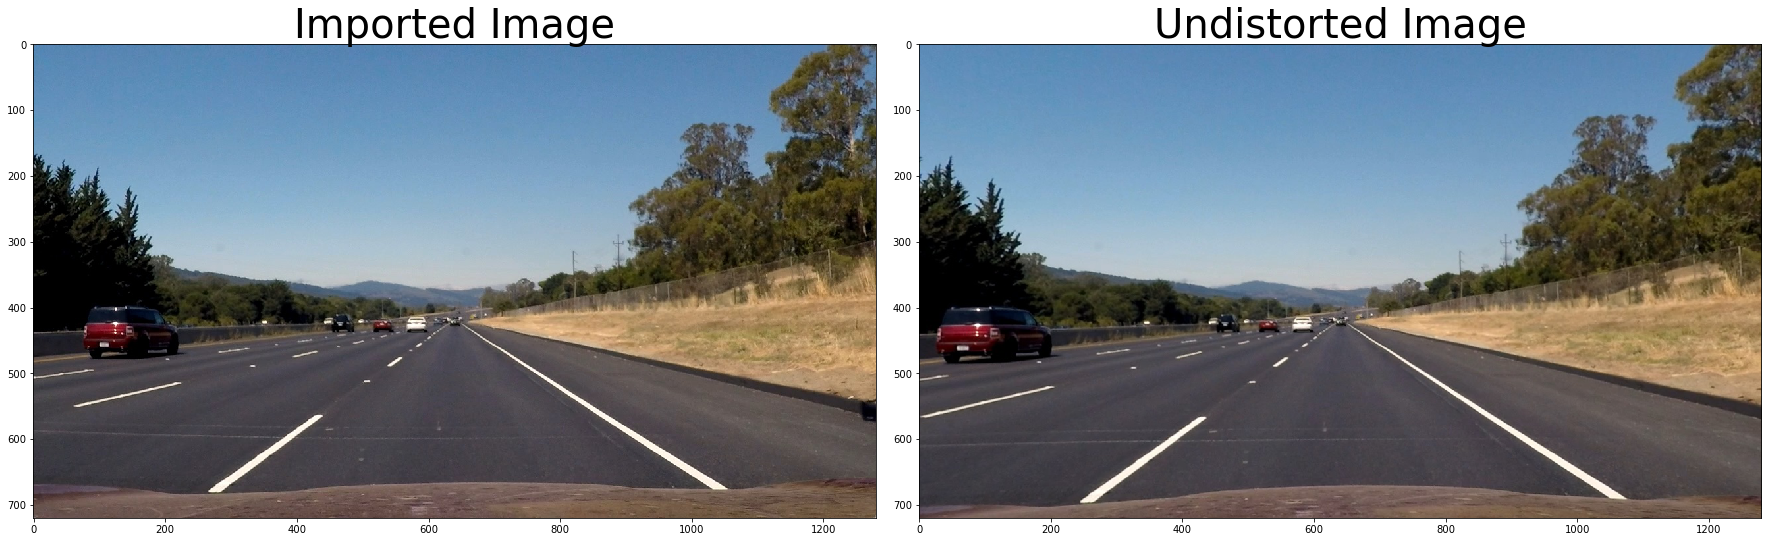

In [78]:
# Display the original image and red channel
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img, cmap = 'gray')
ax1.set_title('Imported Image', fontsize=40)

ax2.imshow(undistorted, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

### 2. RGB Channels:

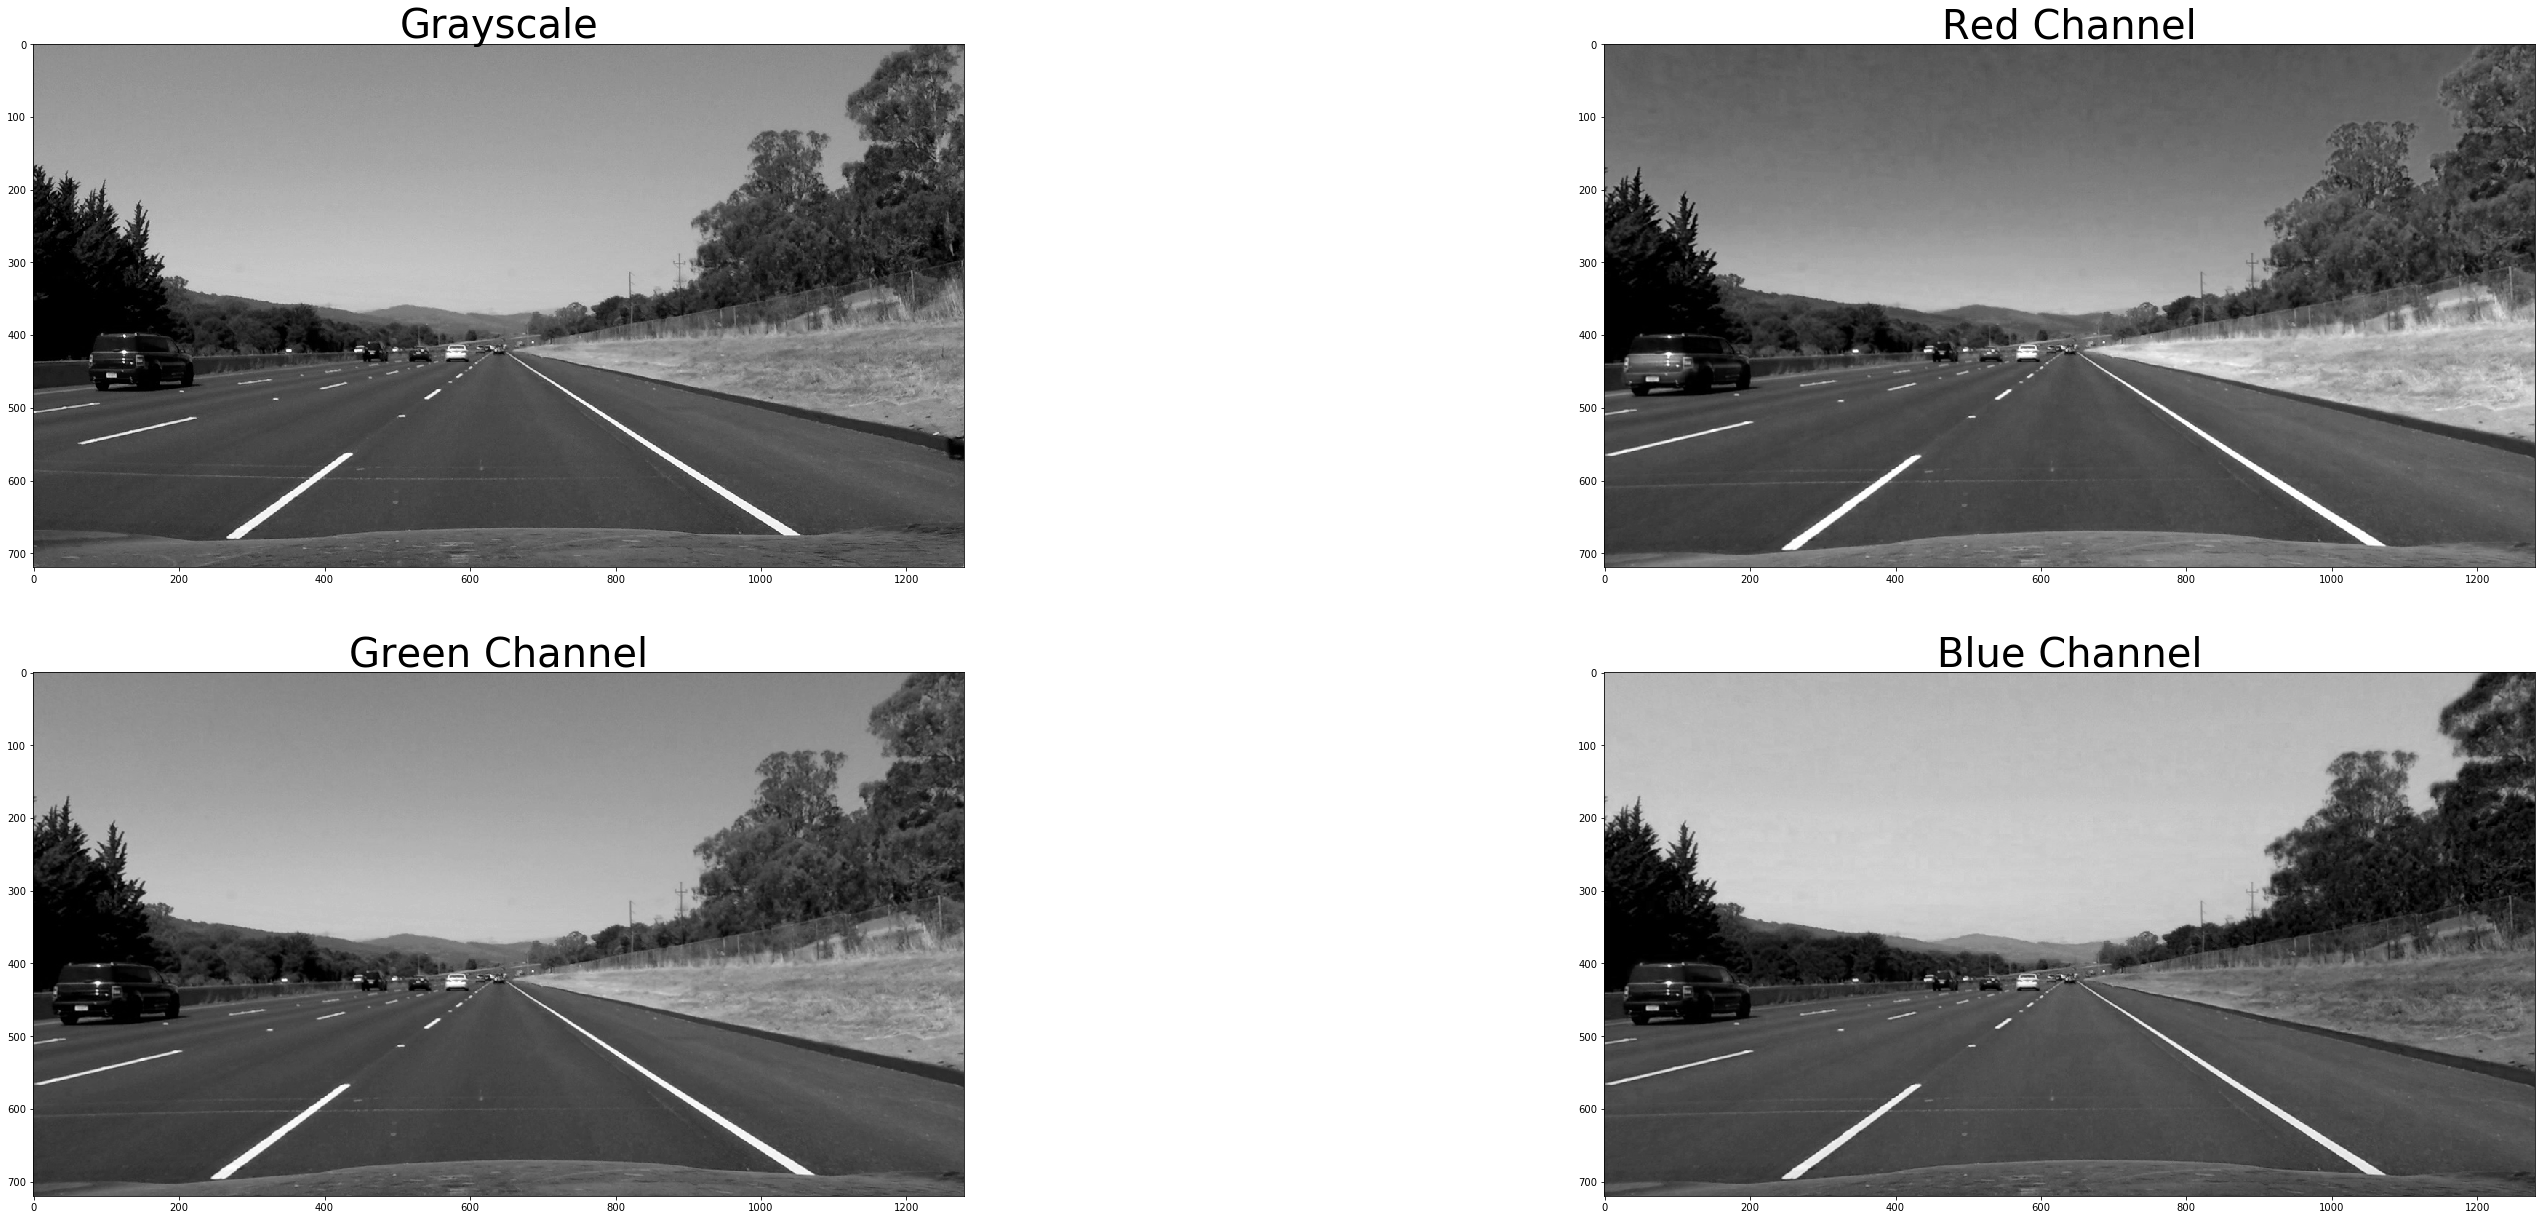

In [79]:
# Display the original image and binary images of R,G,B
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(40, 20))

ax1.imshow(gray, cmap='gray')
ax1.set_title('Grayscale', fontsize=40)

ax2.imshow(R, cmap='gray')
ax2.set_title('Red Channel', fontsize=40)

ax3.imshow(G, cmap='gray')
ax3.set_title('Green Channel', fontsize=40)

ax4.imshow(B, cmap='gray')
ax4.set_title('Blue Channel', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.8, bottom=0.)
plt.show()

### 3. Binary RGB Channels:

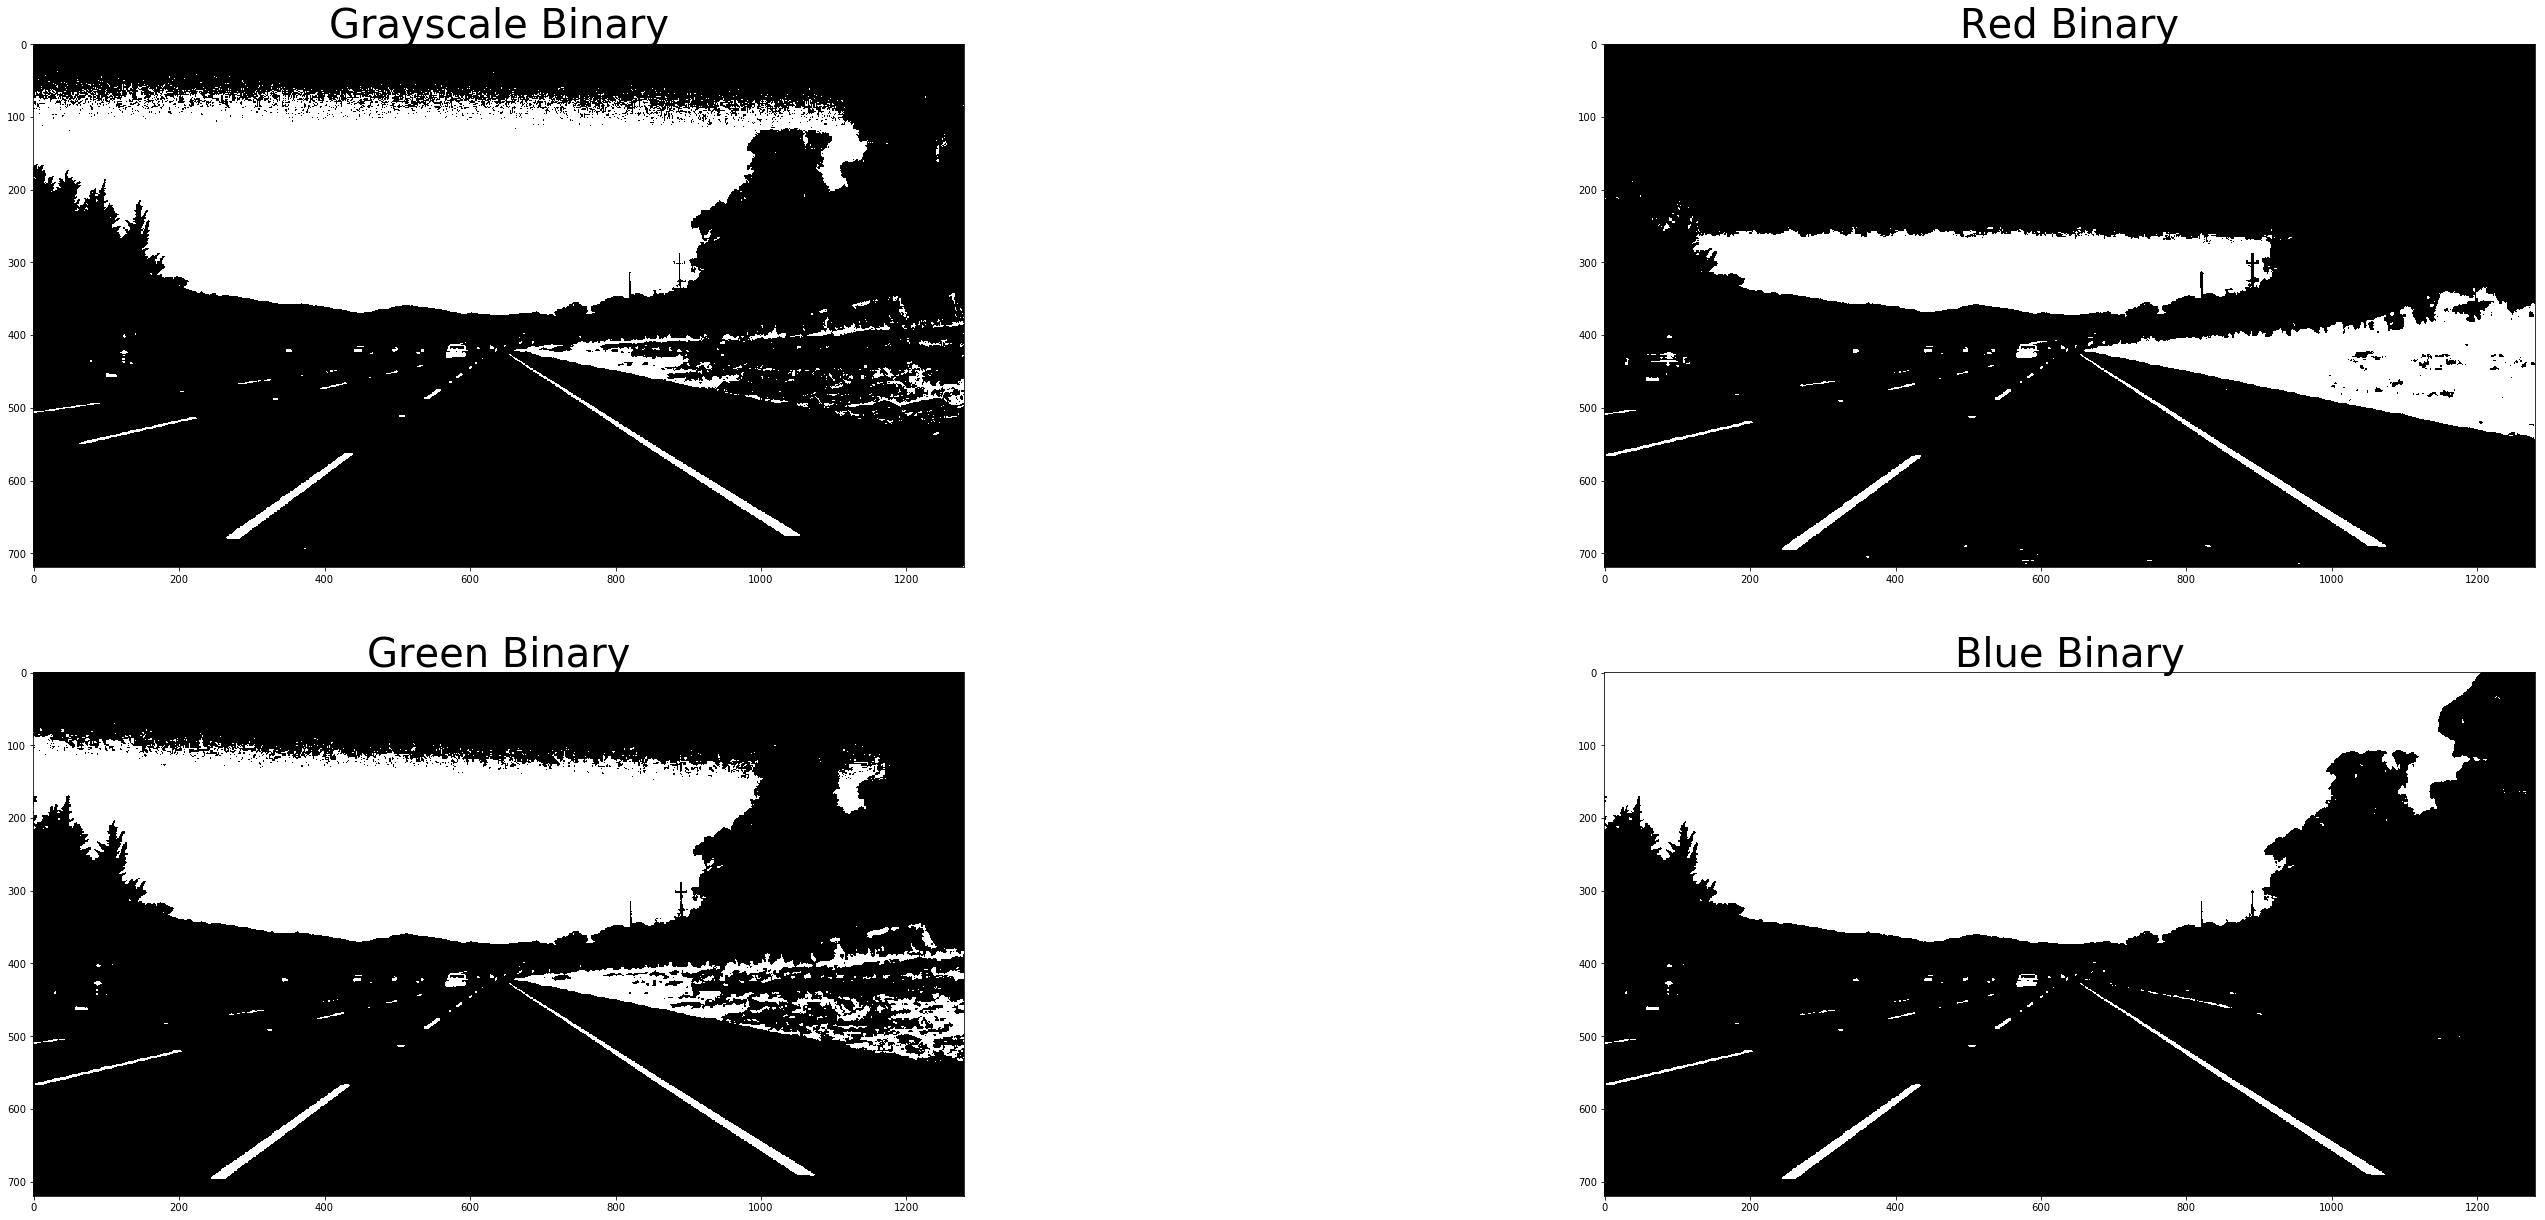

In [80]:
# Display the original image and binary images of R,G,B
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(40, 20))

ax1.imshow(binary_gray, cmap='gray')
ax1.set_title('Grayscale Binary', fontsize=40)

ax2.imshow(binary_R, cmap = 'gray')
ax2.set_title('Red Binary', fontsize=40)

ax3.imshow(binary_G, cmap='gray')
ax3.set_title('Green Binary', fontsize=40)

ax4.imshow(binary_B, cmap = 'gray')
ax4.set_title('Blue Binary', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.8, bottom=0.)
plt.show()

### 4. HLS Color Channels:

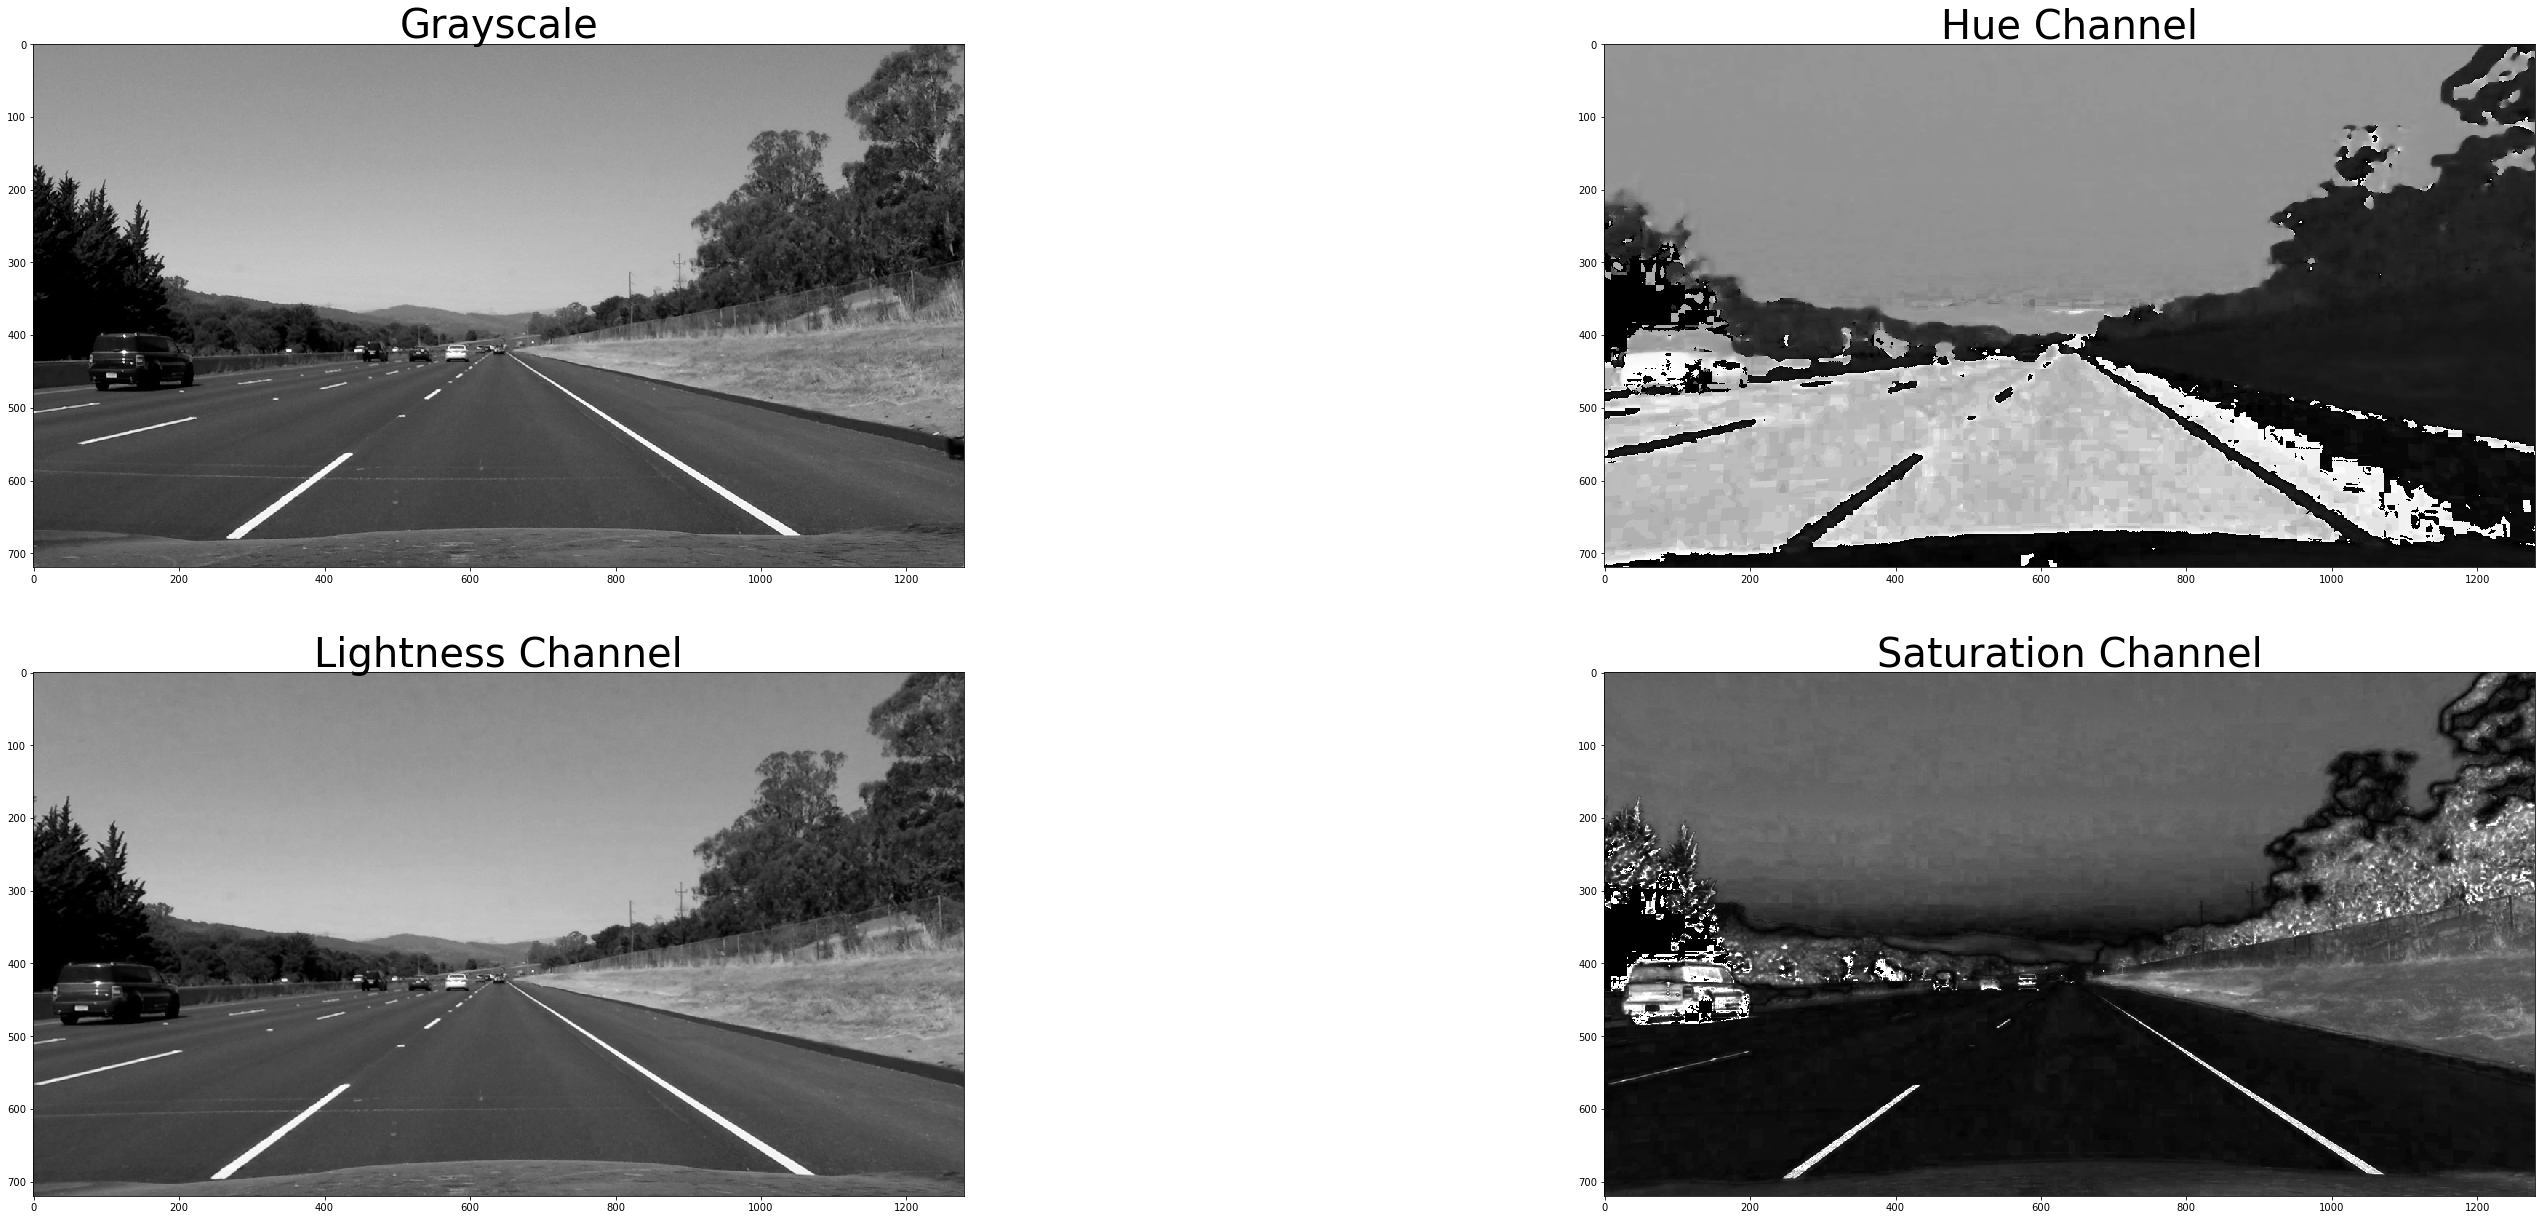

In [81]:
# Display the original image and binary images of R,G,B
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(40, 20))

ax1.imshow(gray, cmap='gray')
ax1.set_title('Grayscale', fontsize=40)

ax2.imshow(H, cmap='gray')
ax2.set_title('Hue Channel', fontsize=40)

ax3.imshow(L, cmap='gray')
ax3.set_title('Lightness Channel', fontsize=40)

ax4.imshow(S, cmap='gray')
ax4.set_title('Saturation Channel', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.8, bottom=0.)
plt.show()

### 5. Binary HLS Channels:

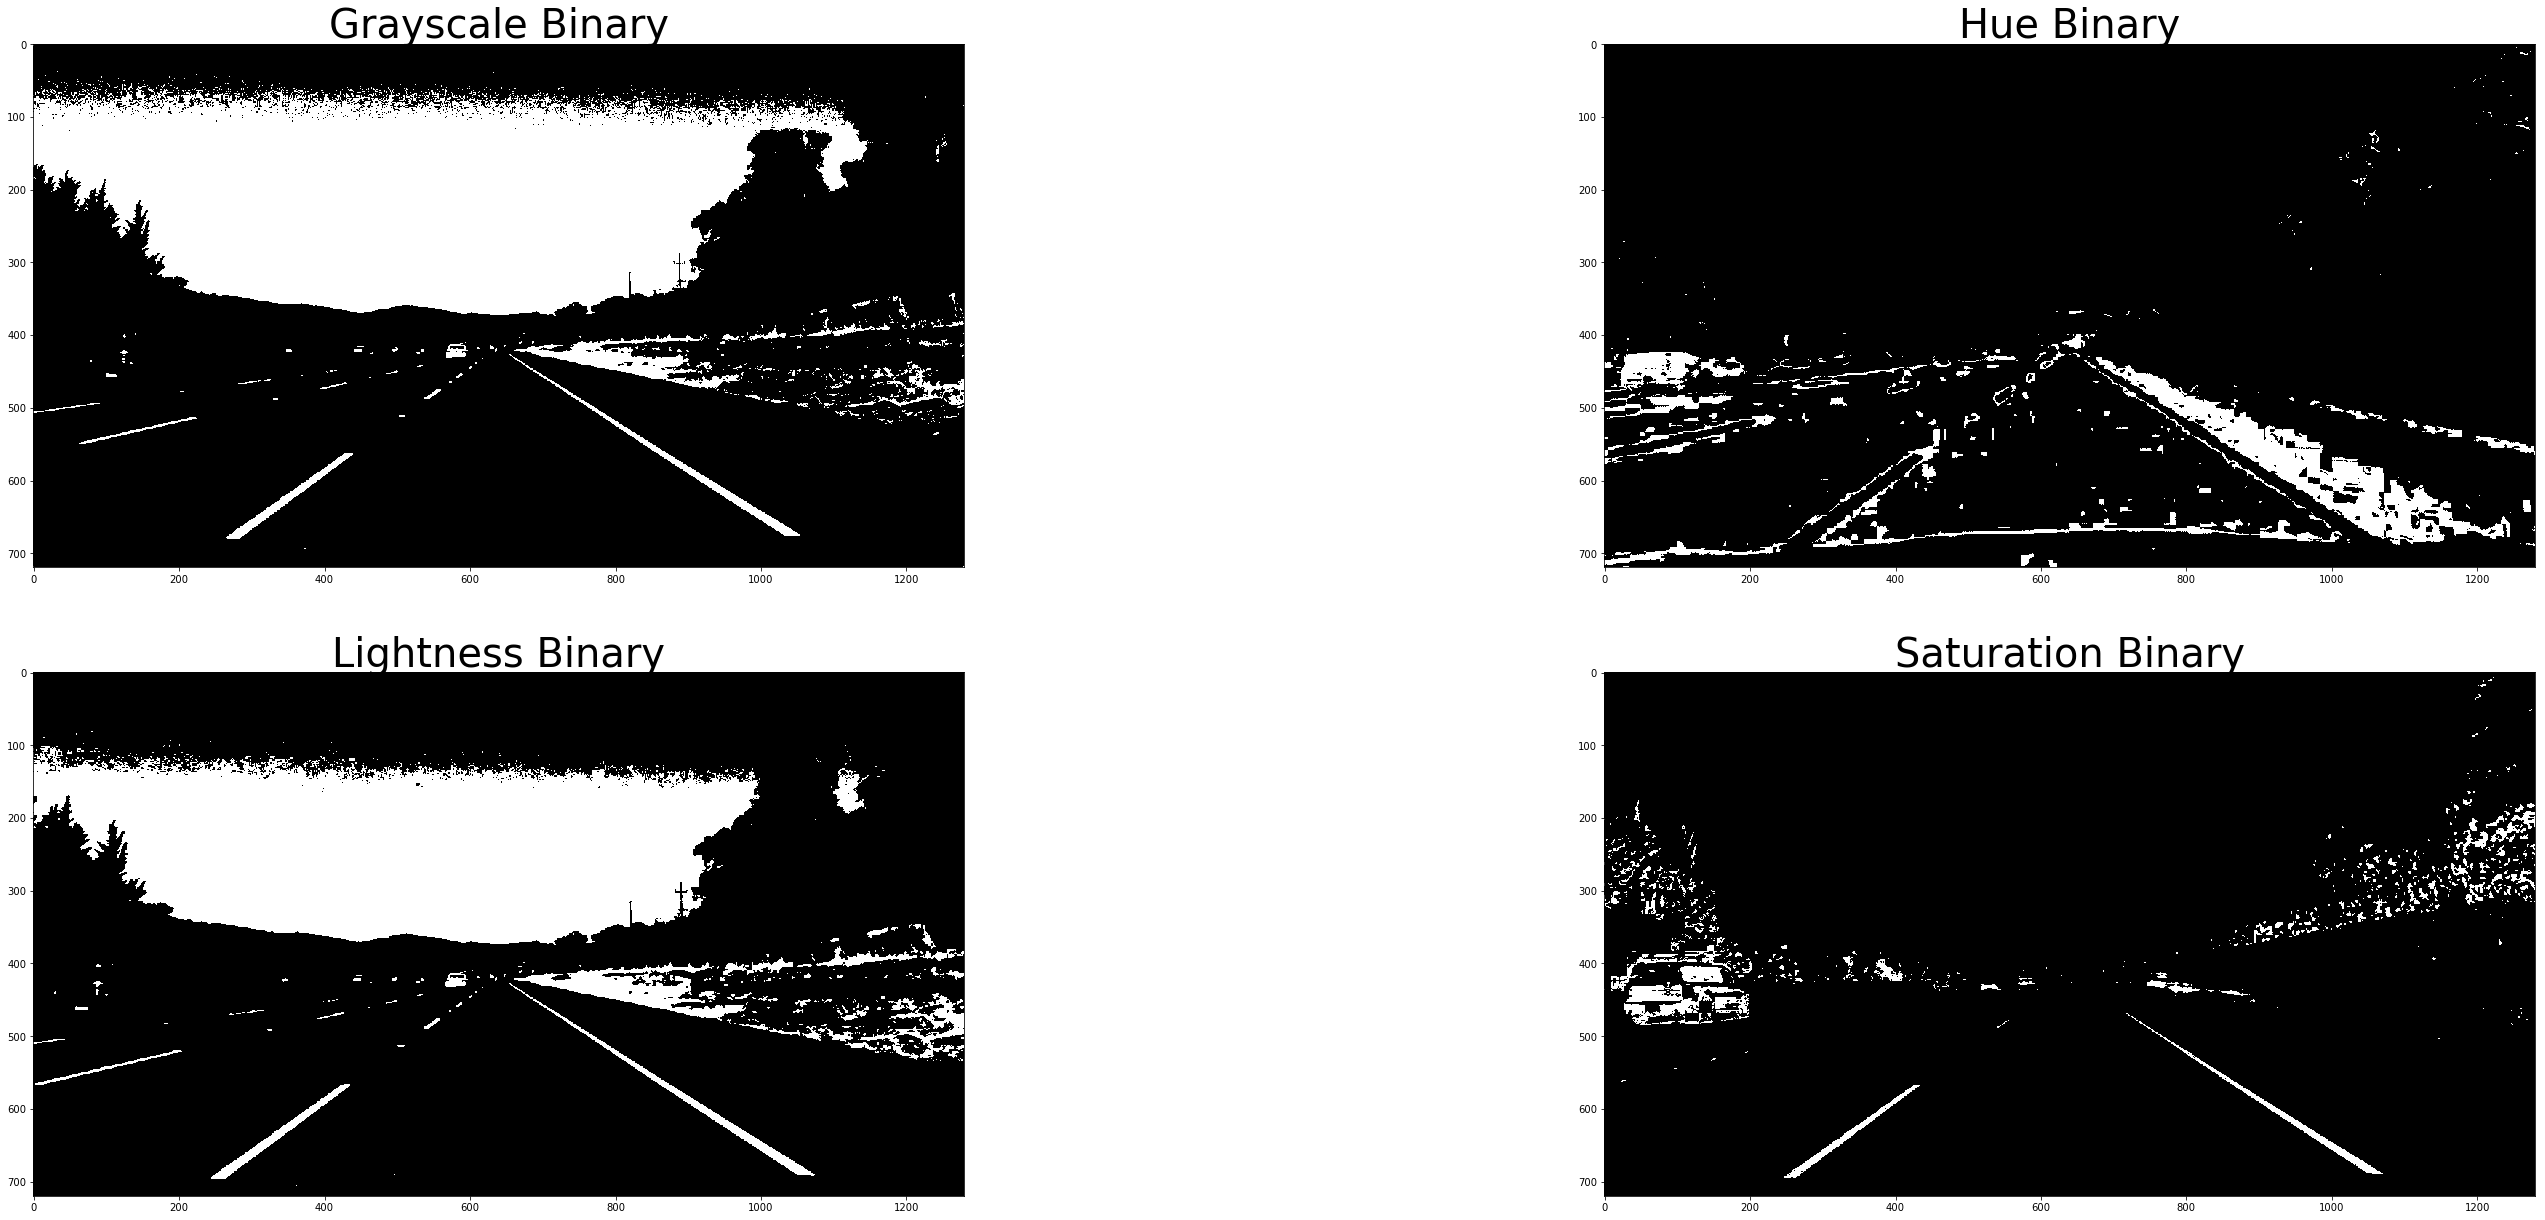

In [83]:
# Display the original image and binary images of R,G,B
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(40, 20))

ax1.imshow(binary_gray, cmap='gray')
ax1.set_title('Grayscale Binary', fontsize=40)

ax2.imshow(binary_H, cmap = 'gray')
ax2.set_title('Hue Binary', fontsize=40)

ax4.imshow(binary_S, cmap='gray')
ax4.set_title('Saturation Binary', fontsize=40)

ax3.imshow(binary_L, cmap = 'gray')
ax3.set_title('Lightness Binary', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.8, bottom=0.)
plt.show()

### 6. Thresholding:

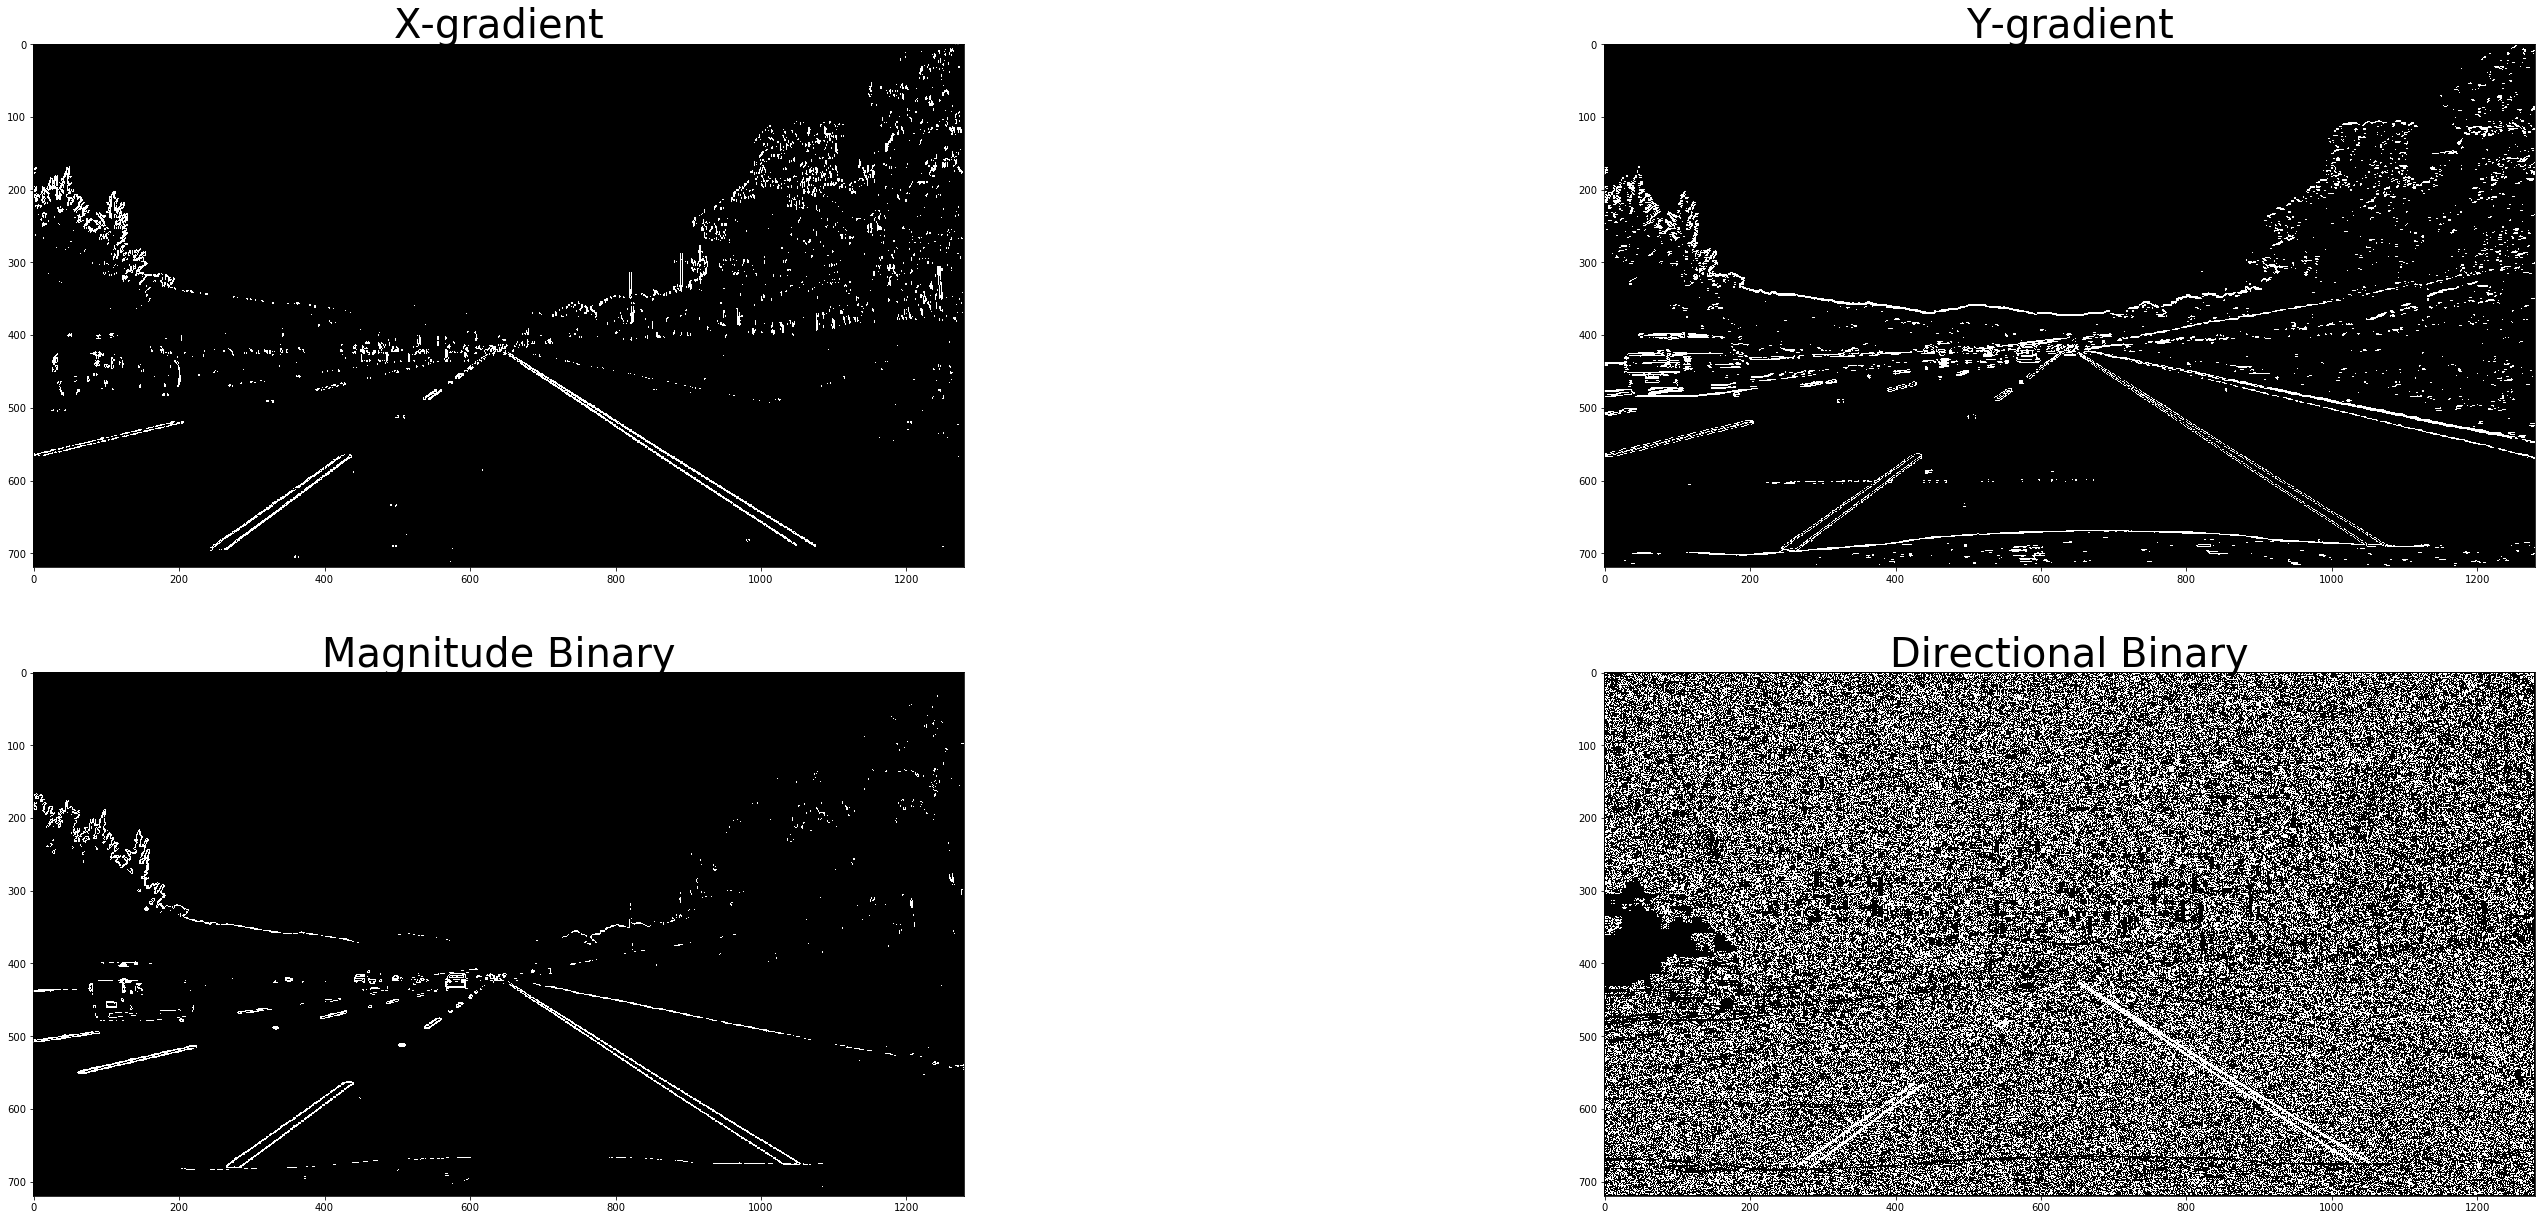

In [84]:
# Display the original image and binary images of R,G,B
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(40, 20))

ax1.imshow(gradx, cmap='gray')
ax1.set_title('X-gradient', fontsize=40)

ax2.imshow(grady, cmap = 'gray')
ax2.set_title('Y-gradient', fontsize=40)

ax3.imshow(mag_binary, cmap='gray')
ax3.set_title('Magnitude Binary', fontsize=40)

ax4.imshow(dir_binary, cmap = 'gray')
ax4.set_title('Directional Binary', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.8, bottom=0.)
plt.show()

### 7. Combining these thresholdings:

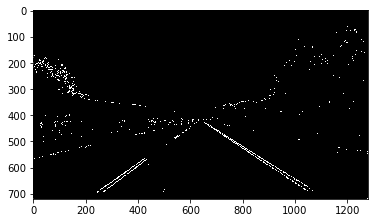

In [85]:
plt.imshow(combined, cmap='gray')
plt.show()

### 8. Combining result and Saturation Channel:

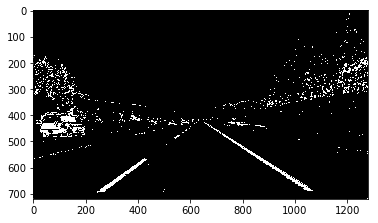

In [86]:
plt.imshow(new_combined, cmap = 'gray')
plt.show()

### 9. Birds-eye View:

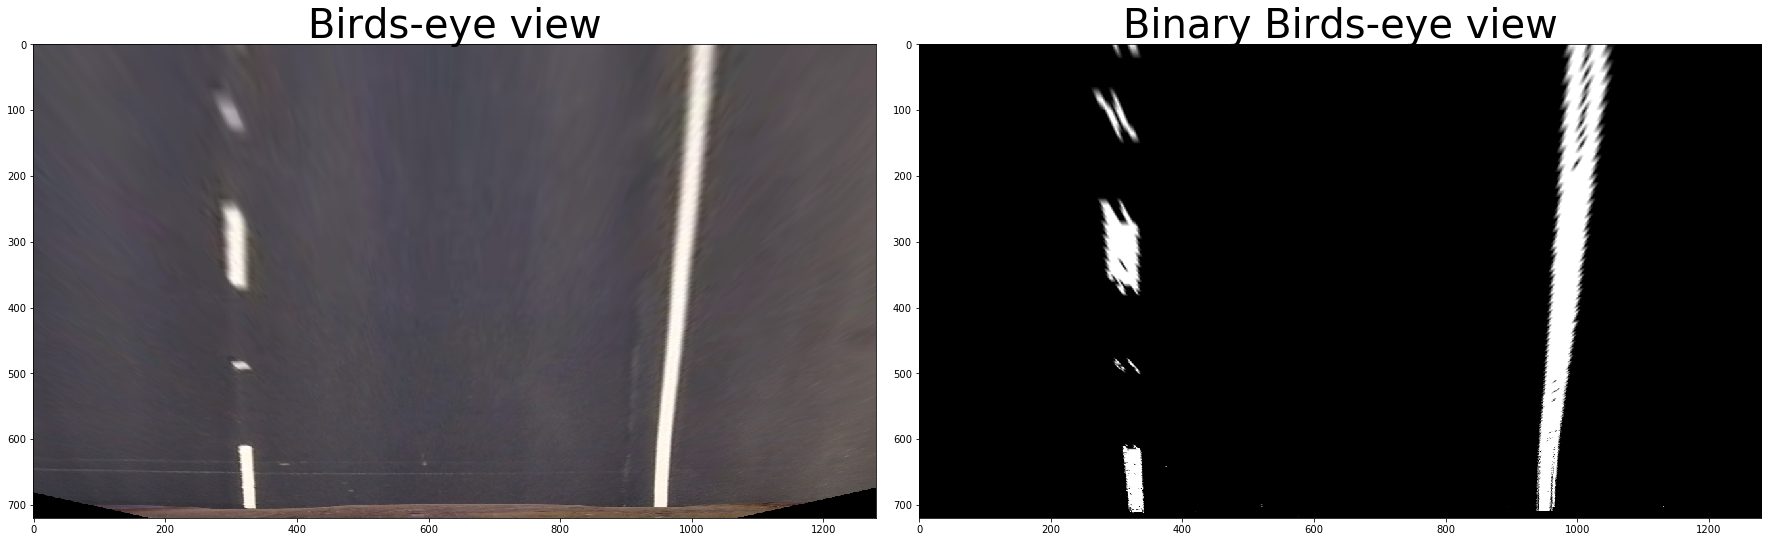

True

In [96]:
# Display the original image and red channel
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warped_img, cmap = 'gray')
ax1.set_title('Birds-eye view', fontsize=40)

ax2.imshow(binary_warped_B, cmap='gray')
ax2.set_title('Binary Birds-eye view', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

warped_img = cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB)
cv2.imwrite('./birdseye.jpg', warped_img)

### 10. Histogram:

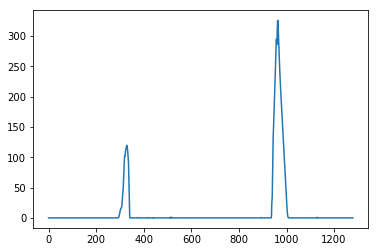

In [91]:
plt.plot(histogram)
plt.show()

### 11. Finding Lanes:

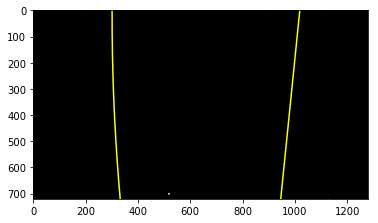

In [92]:
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

### 12. Fast Lanes:

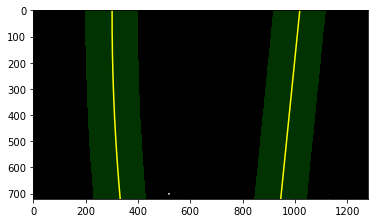

In [93]:
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

### 13. Augumentation:

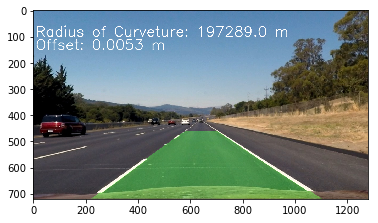

In [94]:
plt.imshow(augumented, cmap='gray')
plt.show()